In [33]:
# Used notebook for reference

# https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python/notebook

# Claim Frequency Modeling

#### What are the benefits of machine learning techniques for car insurance pricing? To answer this question, the claims frequency for a large French motor third party liability insurance portfolio is modeled and predicted. In a first classical approach, generalized linear models (GLM) are used and a benchmark is defined. Then, the gradient tree boosting machines (GBM) CatBoost, LightGBM and XGBoost, known for their prediction accuracy, are applied with and without monotone constraints and the explainability of the models is investigated. Finally, artificial neural networks, including the combined actuarial neural network (CANN), are used. It is shown that both neural networks and GBMs can at least be used to improve classical models. Furthermore, the GBMs are shown to be the superior forecasting models, even when monotone constraints are applied to account for plausible tariff structures.

# Prepare the data

In [3]:
## Imports

import os
os.environ["PYTHONWARNINGS"] = "ignore"

seed = 23

import subprocess
import time
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from scipy.stats import uniform, loguniform
# pip install pyarrow_hotfix # due to PyArrow security vulnerability 
import pyarrow_hotfix


# Explain the things done by AI
import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG, Image

sns.set(rc = {"figure.figsize": (12, 7)})
sns.set_theme()

# Import Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Tuning of model
from sklearn.model_selection import GridSearchCV


In [8]:
# Read the frequency data

df_raw = pd.read_csv("Dataset/freMTPL2freq.csv")

df_raw.IDpol = df_raw.IDpol.astype(int)
df_raw["Exposure"] = np.minimum(1, df_raw.Exposure)
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)


# Read the Another fold

df_folds = pd.read_csv("Dataset/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int)

df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')


print('Rows and columns: ', df.shape[0], ' x ', df.shape[1])
print("\nCheck the end of the dataset")
df.tail(6)

Rows and columns:  678013  x  13

Check the end of the dataset


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold
678007,6114325,0,0.005479,E,6,4,40,68,B12,Regular,2733,R93,2
678008,6114326,0,0.002740,E,4,0,54,50,B12,Regular,3317,R93,3
678009,6114327,0,0.002740,E,4,0,41,95,B12,Regular,9850,R11,5
678010,6114328,0,0.002740,D,6,2,45,50,B12,Diesel,1323,R82,5
678011,6114329,0,0.002740,B,4,0,60,50,B12,Regular,95,R26,3
678012,6114330,0,0.002740,B,7,6,29,54,B12,Diesel,65,R72,5


In [6]:
df_raw.columns

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region'],
      dtype='object')

In [10]:
# Take claim number from severity file

sev = pd.read_csv("Dataset/freMTPL2sev.csv")

sev["ClaimNb"] = 1
sev_agg = sev.groupby("IDpol").sum("ClaimNb").drop(columns = ["ClaimAmount"])

sev_agg.head(5)


,ClaimNb
IDpol,
139,1
190,1
414,1
424,2
463,1


In [11]:
df = pd.merge(df.drop(columns = ['ClaimNb']), sev_agg, on = 'IDpol', how = 'left').fillna(0)

df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

df.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,2.997021,0.038945
std,1.641783e+06,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,1.413916,0.205026
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,1.000000,0.000000
25%,1.157951e+06,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,2.000000,0.000000
50%,2.272152e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,3.000000,0.000000
75%,4.046274e+06,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,4.000000,0.000000
max,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,5.000000,4.000000


In [14]:
df.isna().sum()

IDpol         0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
fold          0
ClaimNb       0
dtype: int64

<Axes: title={'center': 'Histogram of the exposure'}, ylabel='Frequency'>

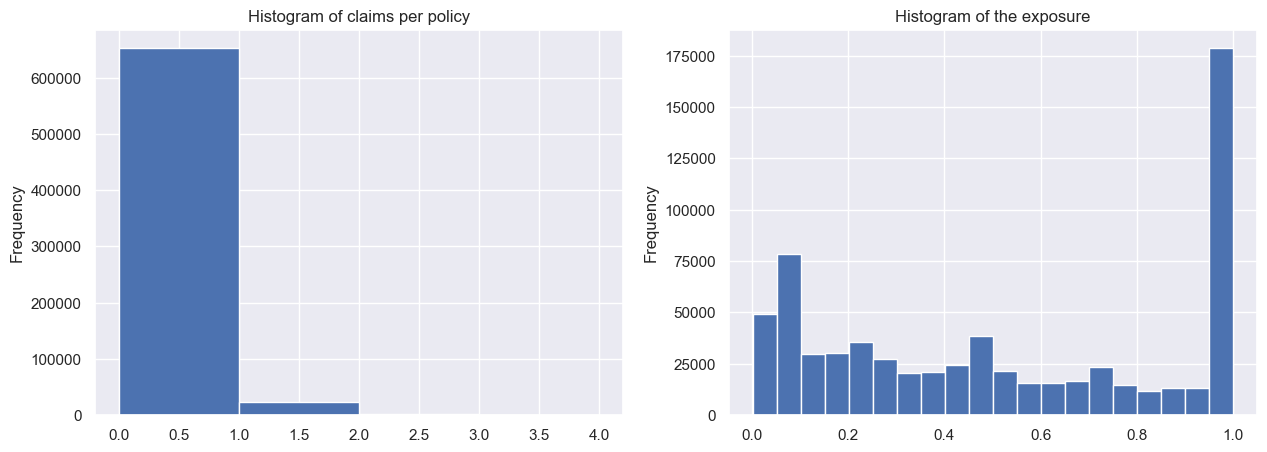

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax1.set_title("Histogram of claims per policy")
ax2.set_title("Histogram of the exposure")

df.ClaimNb.plot.hist(bins = 4, ax = ax1)
df.Exposure.plot.hist(bins = 20, ax = ax2)

In [17]:
df.ClaimNb.value_counts()

ClaimNb
0.0    653069
1.0     23571
2.0      1298
3.0        62
4.0        13
Name: count, dtype: int64

#### As expected, most policies are free of claims. We observe a significant proportion of policies with an exposure value of less than 0.5 and therefore expect a large difference between the exposure-weighted and the unweighted claims frequency. In addition we calculate the annualized claims frequency variable.

In [18]:
df["frequency"] = df["ClaimNb"] / df["Exposure"]

Text(0.5, 0.98, 'Modified Claims Frequency')

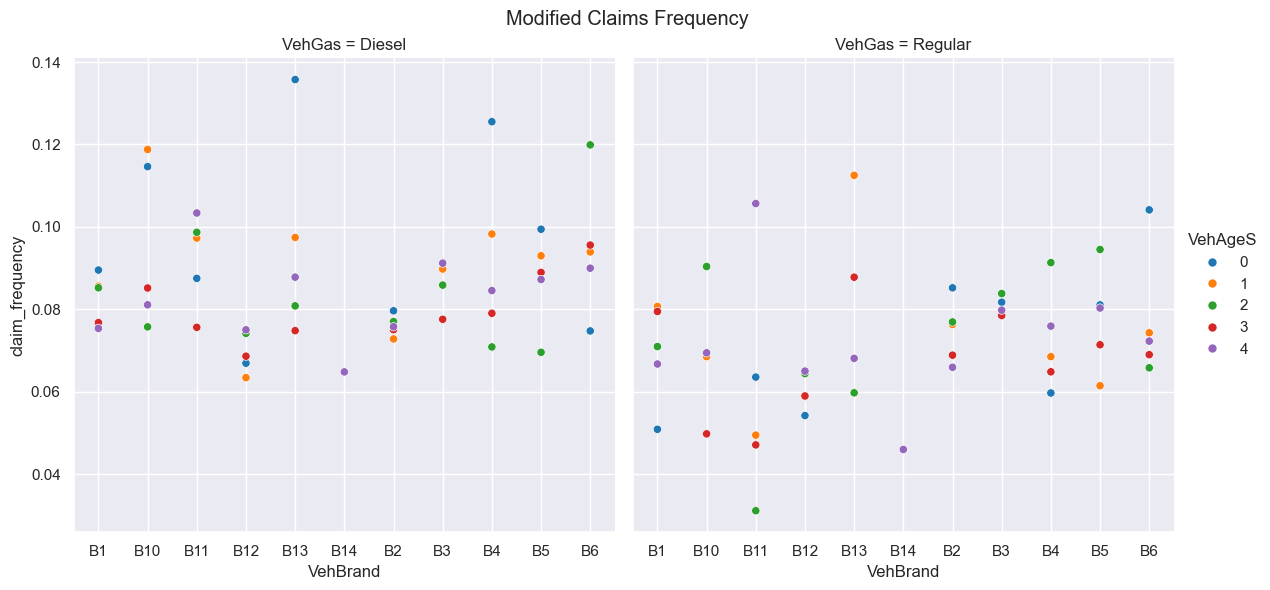

In [28]:
df_eda = df.copy()
df_eda["VehAgeS"] = np.minimum(4, df_eda.VehAge)
agg = df_eda.groupby(["VehBrand", "VehAgeS", "VehGas"])[["ClaimNb", "Exposure"]].sum()
agg["claim_frequency"] = agg["ClaimNb"] / agg["Exposure"]
agg = agg.query("Exposure >= 100").reset_index()

import seaborn as sns
rp = sns.relplot(data=agg, x="VehBrand", y="claim_frequency", col="VehGas",
                 hue="VehAgeS", palette="tab10", kind="scatter", height=6)
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle("Modified Claims Frequency")

In [ ]:
# BonusMalus (claims free discount)

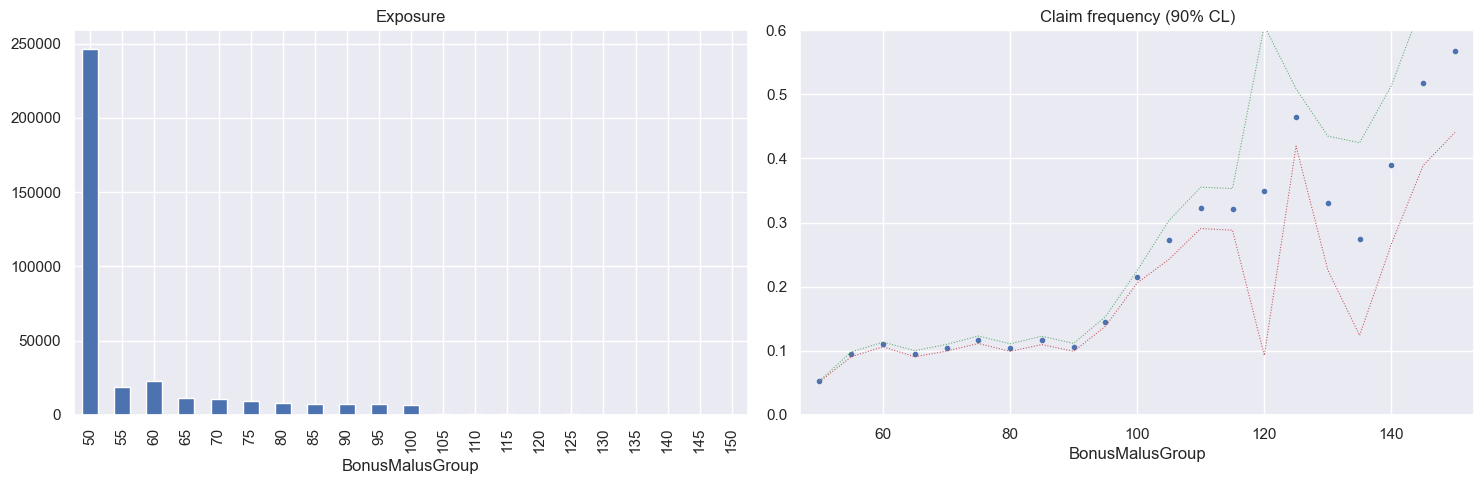

In [27]:
df_eda = df.copy()
df_eda["BonusMalus"] = np.minimum(df_eda.BonusMalus, 150)
df_eda["BonusMalusGroup"] = (df_eda.BonusMalus // 5 * 5).astype(int)

# Aggregate values
grouped = df_eda.groupby("BonusMalusGroup")
exposure = grouped.Exposure.sum()
claims = grouped.ClaimNb.sum()
freq = claims / exposure
z = 1.645 * np.sqrt(claims) / exposure

# Quick plot
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
exposure.plot.bar(ax=ax1, title="Exposure")
pd.DataFrame({
    "Frequency": freq,
    "upper": freq + z,
    "lower": freq - z
}).plot(ax=ax2, style=[".", ":", ":"], color=["b", "g", "r"], lw=0.75, ylim=(0,0.6), xlim=(50-3,153), legend=False, title="Claim frequency (90% CL)")

plt.tight_layout()
plt.show()


In [ ]:
data2 = df.copy()
data2["AreaGLM"] = data2.Area.factorize()[0]
data2["VehPowerGLM"] = np.minimum(9, data2.VehPower)
data2["VehAgeGLM"] = np.select(
    [data2.VehAge >= 11, data2.VehAge >= 1],
    [3, 2],
    default = 1
)
data2["BonusMalusGLM"] = np.minimum(150, data2.BonusMalus)
data2["DensityGLM"] = np.log(data2.Density)

data2.head(5)

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold,ClaimNb,frequency,AreaGLM,VehPowerGLM,VehAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1,0.0,0.0,0,5,1,50,7.104144
1,3,0.77,D,5,0,55,50,B12,Regular,1217,R82,5,0.0,0.0,0,5,1,50,7.104144
2,5,0.75,B,6,2,52,50,B12,Diesel,54,R22,1,0.0,0.0,1,6,2,50,3.988984
3,10,0.09,B,7,0,46,50,B12,Diesel,76,R72,1,0.0,0.0,1,7,1,50,4.330733
4,11,0.84,B,7,0,46,50,B12,Diesel,76,R72,2,0.0,0.0,1,7,1,50,4.330733


In [31]:
data2.VehAgeGLM.value_counts()

VehAgeGLM
2    434492
3    185782
1     57739
Name: count, dtype: int64

In [36]:
# Function CF2: Print claim frequency
def CF2(txt, l_c, l_x, t_c, t_x):
    print("%s: %.2f %% / %.2f %%" % (txt, sum(l_c)/sum(l_x)*100, sum(t_c)/sum(t_x)*100))

In [34]:
# Convert categorical variable into dummy/indicator variables.
df_ml = pd.get_dummies(df, drop_first=False, dtype='int')
print(df_ml.shape)
df_ml.head()

(678013, 51)


,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb,frequency,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1,0.10,5,0,55,50,1217,1,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3,0.77,5,0,55,50,1217,5,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,0.75,6,2,52,50,54,1,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,0.09,7,0,46,50,76,1,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,11,0.84,7,0,46,50,76,2,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [37]:
# generate sample with encoded data
learn = df_ml.loc[df_ml.fold != 5,].copy()    # 80%
test = df_ml.loc[df_ml.fold == 5,].copy()     # 20%
# Additionally, let's divide learn into train and validation (e.g. to use it for early stopping)
train = df_ml.loc[df_ml.fold < 4,].copy()    # 60%
val = df_ml.loc[df_ml.fold == 4,].copy()    # 20%
CF2("Claim Frequency (Actual) Train/Val", train.ClaimNb, train.Exposure, val.ClaimNb, val.Exposure)

Claim Frequency (Actual) Train/Val: 7.39 % / 7.29 %


In [39]:
no_feature_list = ['IDpol', 'ClaimNb', 'Exposure', 'frequency', 'fold']
# labels
y_train  = train.ClaimNb
y_val    = val.ClaimNb
y_test   = test.ClaimNb
y_learn  = learn.ClaimNb
# features
X_train  = train.drop(no_feature_list, axis=1)
X_val    = val.drop(no_feature_list, axis=1)
X_test   = test.drop(no_feature_list, axis=1)
X_learn  = learn.drop(no_feature_list, axis=1)
feature_names = X_learn.columns
X_learn.head(3)


,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,VehBrand_B3,VehBrand_B4,VehBrand_B5,VehBrand_B6,VehGas_Diesel,VehGas_Regular,Region_R11,Region_R21,Region_R22,Region_R23,Region_R24,Region_R25,Region_R26,Region_R31,Region_R41,Region_R42,Region_R43,Region_R52,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,5,0,55,50,1217,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6,2,52,50,54,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,0,46,50,76,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Basic CatBoost Model

In [45]:
def LearnPool(X, y, exposure):
    label = (y / exposure)
    return Pool(data = X, label = label, weight = exposure)

learn_pool = LearnPool(X_learn, y = y_learn, exposure = learn.Exposure)
train_pool = LearnPool(X_train, y_train, train.Exposure)
val_pool = LearnPool(X_val, y_val, val.Exposure)
test_pool = LearnPool(X_test, y_test, test.Exposure)

In [46]:
model_cb1 = CatBoostRegressor(objective='Poisson', random_seed=seed) 

tic = time.time()
model_cb1.fit(learn_pool, logging_level='Silent')
print("time (sec):" + "%6.0f" % (time.time() - tic))

print(model_cb1.get_all_params())

time (sec):    90
{'nan_mode': 'Min', 'eval_metric': 'Poisson', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 23, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Poisson', 'learning_rat

In [49]:
# Modified function PDX: Weighted Poisson Deviance
def PDW(pred, obs, ex=None):
    if ex is None:
        ex = np.ones(len(obs))
    deviance = 200 * np.sum(ex * (pred - obs + np.log((obs / pred) ** obs))) / np.sum(ex)
    return deviance

In [47]:
# Function PDW2: Print Poisson Deviance learn/test
def PDW2(txt, l_c, l_x, l_e, t_c, t_x, t_e):
    print("%s, Learn/Test: %.2f %% / %.2f %%" % (txt, PDW(l_c, l_x, l_e), PDW(t_c, t_x, t_e)))

In [50]:
learn["fitCB1"] = model_cb1.predict(learn_pool) * learn.Exposure

test["fitCB1"] = model_cb1.predict(test_pool) * test.Exposure


PDW2("Poisson Deviance CB1 - unconstraint", learn.fitCB1, learn.ClaimNb, learn.Exposure, test.fitCB1, test.ClaimNb, test.Exposure)

Poisson Deviance CB1 - unconstraint, Learn/Test: 28.18 % / 28.75 %


In [52]:
def plot_eval(d,x1,x2,t): 
    """
    This function graphically represents the forecast quality of the fitted models.
    Input parameter: Dictionary with model names, PD and Text
    """
    df_eval = pd.DataFrame(d)
    sns.set_style('darkgrid')
    plt.title("GLM2-Improvement-Index of the fitted models: " + t)
    sns.barplot(data = df_eval, x = "improvement", y = "modelname", color = 'magenta')
    plt.xlim(x1, x2)
    plt.show()

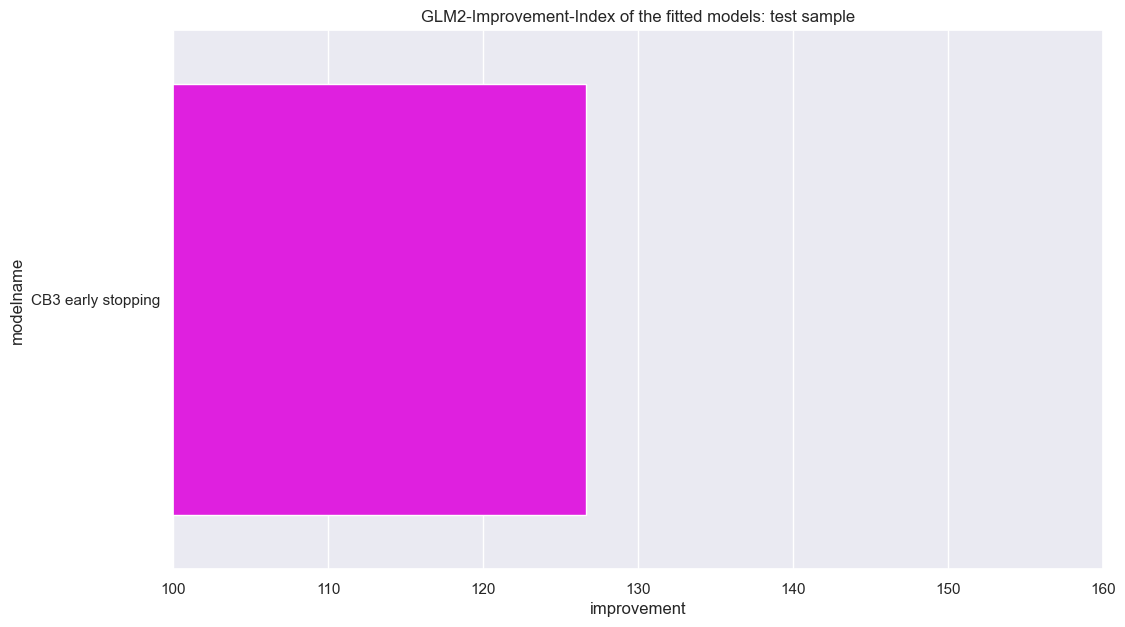

In [101]:
plot_eval(dict, 100, 160, "test sample")

In [55]:
def plot_feature_importance(model, data, top_n=20, model_name=''): 
    """
    This function extracts and plots the most important features (if method feature_importance_ is available) 
    """
    # Extract the most important features and create a Series for plotting
    FI = pd.Series(model.feature_importances_, index=data.columns).nlargest(top_n)
    # Plot the feature importances
    FI.plot(kind='barh')
    plt.gca().invert_yaxis()
    text = 'Model {}: Top {} most important features'.format(model_name, top_n)
    plt.title(text)
    plt.xlabel('Importance')
    plt.show()

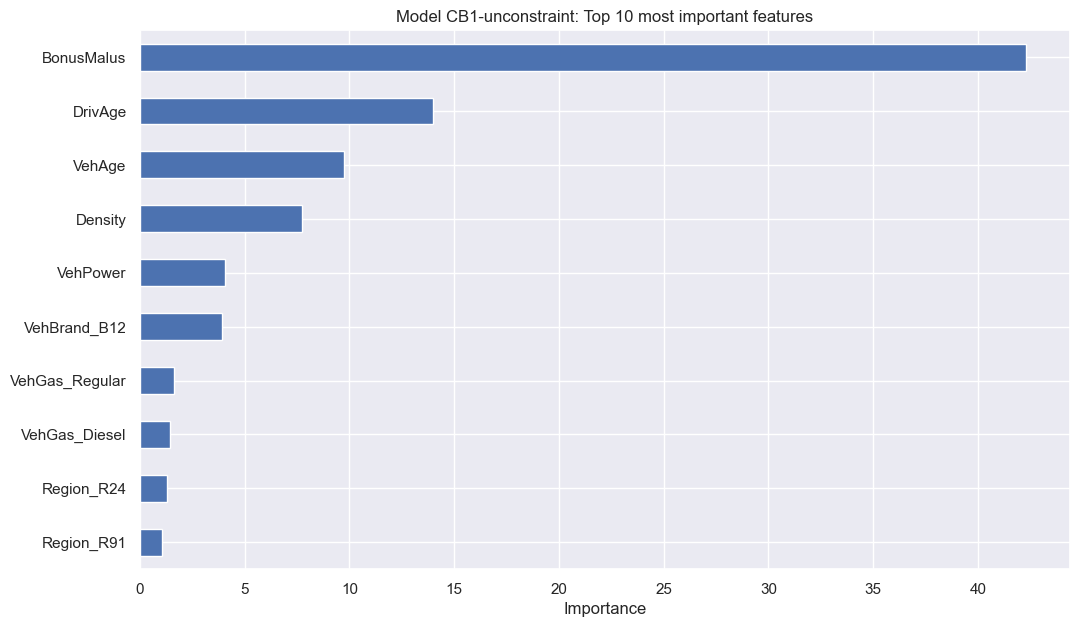

In [56]:
plot_feature_importance(model_cb1, X_learn, 10, "CB1-unconstraint")

In [57]:
explainer1 = shap.TreeExplainer(model_cb1)
shap_values1 = explainer1.shap_values(X_test)


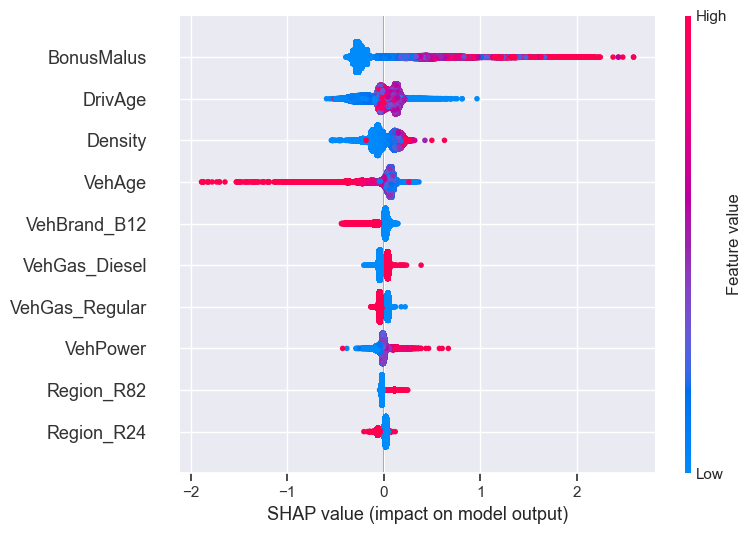

In [58]:
shap.summary_plot(shap_values1, X_test, max_display = 10)

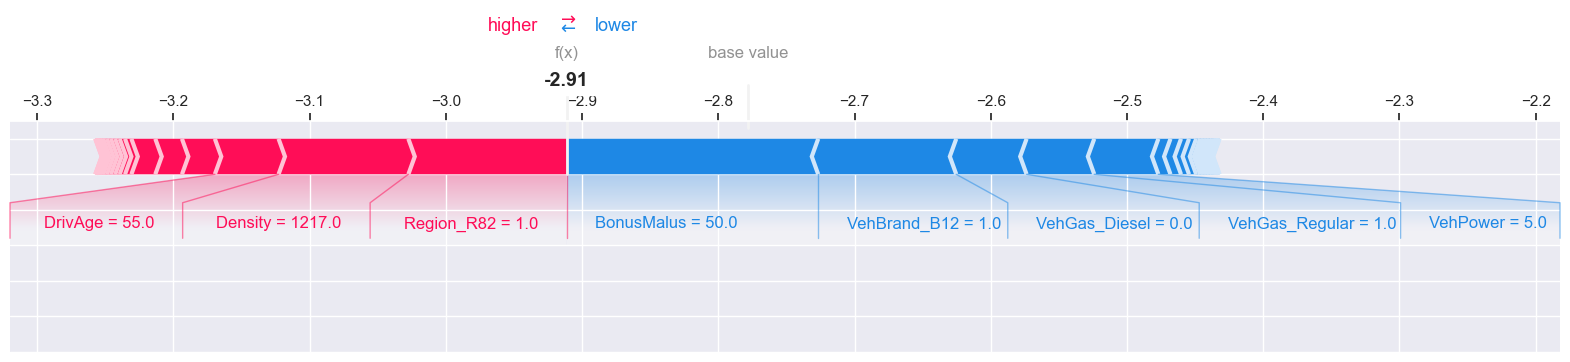

In [78]:
shap.force_plot(explainer1.expected_value, shap_values1[0, :], X_test.iloc[0, :], matplotlib = True)

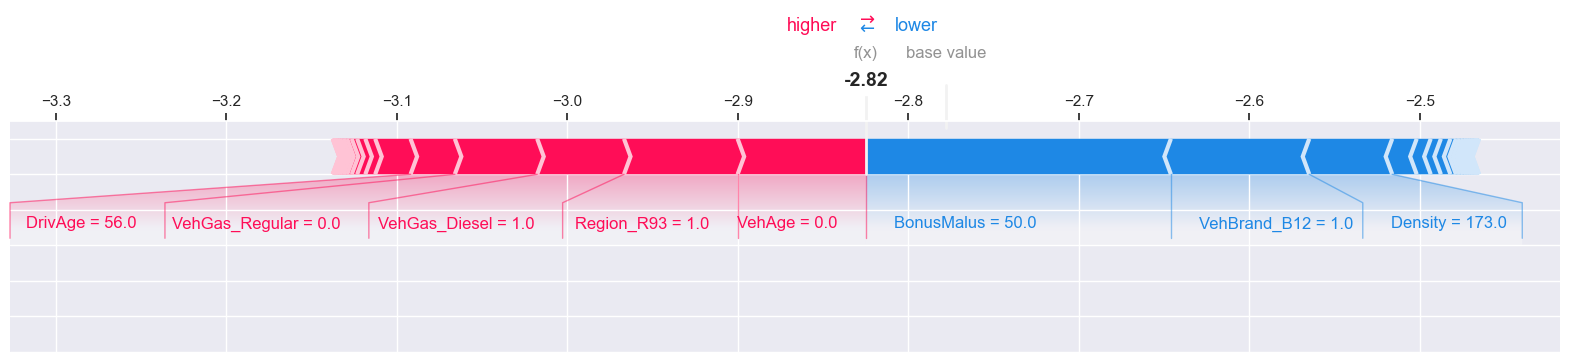

In [62]:
shap.force_plot(explainer1.expected_value, shap_values1[1, :], X_test.iloc[1, :], matplotlib = True)

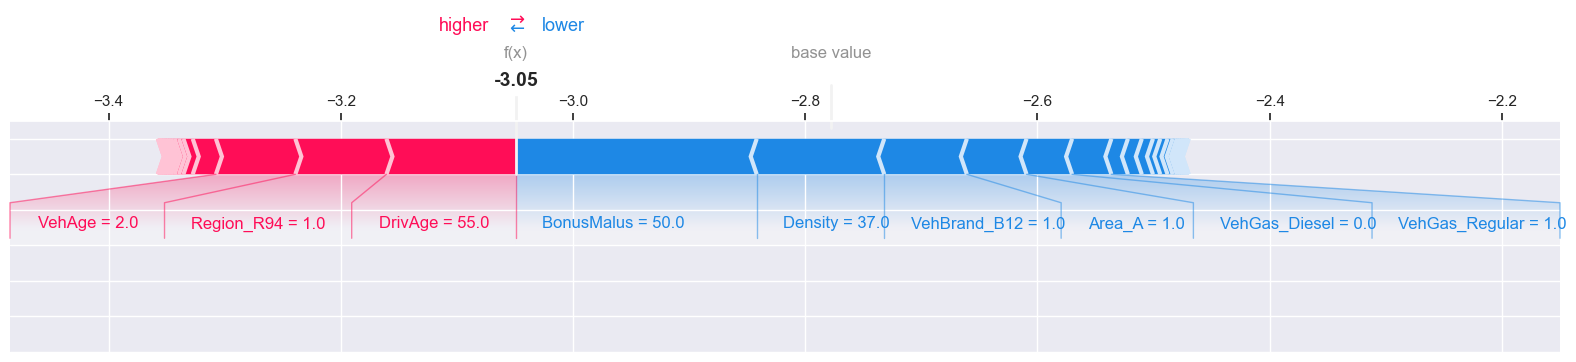

In [63]:
shap.force_plot(explainer1.expected_value, shap_values1[2, :], X_test.iloc[2, :], matplotlib = True)

# Catboost with monetone constraints

### Create monotonic constrain vector

In [71]:
mtc = np.zeros(len(X_learn.columns))
mtc[3] = 1 # Bonus Malus Increasing
X_learn.iloc[0:1, 3]

0    50
Name: BonusMalus, dtype: int64

In [74]:
model_cb2 = CatBoostRegressor(objective = "Poisson", monotone_constraints = mtc, random_seed = seed)

tic = time.time()
model_cb2.fit(learn_pool, logging_level = "Silent")

print("time (sec):" + "%6.0f" % (time.time() - tic))

print(model_cb2.get_all_params())

time (sec):   115
{'nan_mode': 'Min', 'eval_metric': 'Poisson', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'monotone_constraints': {'3': 1}, 'use_best_model': False, 'random_seed': 23, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0.009999999776482582, 'min_data_i

In [75]:
learn["fitCB2"] = model_cb2.predict(learn_pool) * learn.Exposure

test["fitCB2"] = model_cb2.predict(test_pool) * test.Exposure

PDW2("Poisson Deviance CB2", learn.fitCB2, learn.ClaimNb, learn.Exposure, test.fitCB2, test.ClaimNb, test.Exposure)

Poisson Deviance CB2, Learn/Test: 28.66 % / 29.09 %


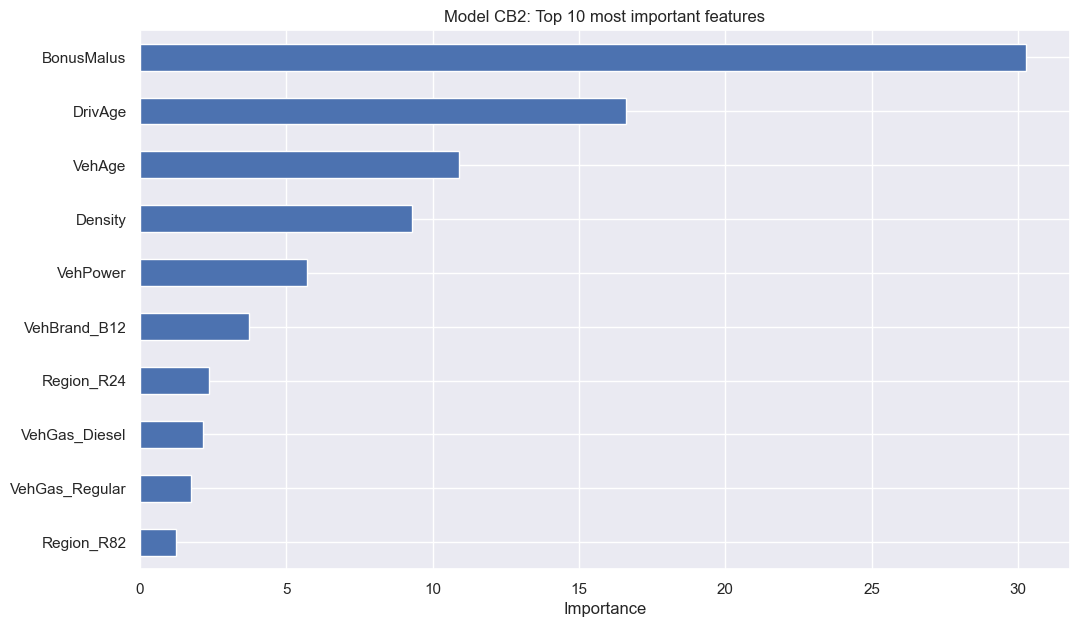

In [76]:
plot_feature_importance(model_cb2, X_learn, 10, "CB2")

# Catboost with early stopping

In [80]:
model_cb3 = CatBoostRegressor(objective = "Poisson", early_stopping_rounds = 20, monotone_constraints = mtc, random_seed = seed)

tic = time.time()
model_cb3.fit(train_pool, eval_set = val_pool, logging_level = "Silent")
print("time (sec): " + "%6.0f" % (time.time() - tic))

print("best iteration: ", model_cb3.get_best_iteration())

time (sec):     31
best iteration:  291


In [83]:
# Defining learn and test sample based on previously defined folds
learn2 = data2.loc[data2.fold != 5,].copy()    # 80%
test2 = data2.loc[data2.fold == 5,].copy()     # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn2.ClaimNb, learn2.Exposure, test2.ClaimNb, test2.Exposure)

Claim Frequency (Actual) Learn/Test: 7.37 % / 7.38 %


In [86]:
# Model INT "predictions"
cf = sum(learn2.ClaimNb) / sum(learn2.Exposure) # claim frequency
learn2["fit_cf"] = cf * learn2.Exposure
test2["fit_cf"] = cf * test2.Exposure
# Print Poisson Deviance
PDW2("Poisson Deviance INT", learn2.fit_cf, learn2.ClaimNb,learn2.Exposure, test2.fit_cf, test2.ClaimNb,test2.Exposure)

# Print claim frequency actual vs predicted (Intercept model)
CF2("Claim Frequency INT, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fit_cf, test2.Exposure)

Poisson Deviance INT, Learn/Test: 31.19 % / 31.09 %
Claim Frequency INT, Test-Sample, Actual/Predicted: 7.38 % / 7.37 %


In [90]:
model = smf.glm("ClaimNb ~ C(VehPowerGLM) + C(VehAgeGLM) + BonusMalusGLM + VehBrand + VehGas + DensityGLM +  C(Region) + AreaGLM + DrivAge + np.log(DrivAge) +  I(DrivAge**2) + I(DrivAge**3) + I(DrivAge**4)",  family=sm.families.Poisson(), offset = np.log(learn2.Exposure), data=learn2)
# Optimizer: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.fit.html
d_glm2 = model.fit(method='newton') # same results with 'nm', 'IRLS'
d_glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542962
Model:                            GLM   Df Residuals:                   542915
Model Family:                 Poisson   Df Model:                           46
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -85952.
Date:                Sun, 16 Nov 2025   Deviance:                   1.3129e+05
Time:                        16:27:13   Pearson chi2:                 9.25e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01128
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              80.5028      6.348     12.681      0.000      68.060      92.945
C(VehPowerGLM)[T.5]     0.0643      0.024      2.631      0.009       0.016       0.112
C(VehPowerGLM)[T.6]     0.0962      0.024      4.014      0.000       0.049       0.143
C(VehPowerGLM)[T.7]     0.0954      0.024      4.020      0.000       0.049       0.142
C(VehPowerGLM)[T.8]     0.1173      0.034      3.483      0.000       0.051       0.183
C(VehPowerGLM)[T.9]     0.2525      0.027      9.480      0.000       0.200       0.305
C(VehAgeGLM)[T.2]       0.0177      0.034      0.520      0.603      -0.049       0.085
C(VehAgeGLM)[T.3]      -0.1804      0.037     -4.926      0.000      -0.252      -0.109
VehBrand[T.B10]        -0.0383      0.045     -0.854      0.393      -0.126       0.050
VehBrand[T.B11]         0.1841      0.046      3.973      0.000       0.093       0.275
VehBrand[T.B12]        -0.2728      0.024    -11.174      0.000      -0.321      -0.225
VehBrand[T.B13]         0.0005      0.051      0.010      0.992      -0.099       0.100
VehBrand[T.B14]        -0.2979      0.104     -2.870      0.004      -0.501      -0.094
VehBrand[T.B2]         -0.0057      0.019     -0.294      0.769      -0.043       0.032
VehBrand[T.B3]          0.0409      0.027      1.529      0.126      -0.012       0.093
VehBrand[T.B4]          0.0301      0.036      0.827      0.408      -0.041       0.102
VehBrand[T.B5]          0.0764      0.031      2.468      0.014       0.016       0.137
VehBrand[T.B6]          0.0416      0.034      1.207      0.227      -0.026       0.109
VehGas[T.Regular]      -0.1733      0.015    -11.611      0.000      -0.203      -0.144
C(Region)[T.R21]       -0.0062      0.129     -0.048      0.961      -0.258       0.246
C(Region)[T.R22]        0.1443      0.068      2.119      0.034       0.011       0.278
C(Region)[T.R23]       -0.0410      0.080     -0.511      0.609      -0.198       0.116
C(Region)[T.R24]       -0.0247      0.031     -0.790      0.430      -0.086       0.037
C(Region)[T.R25]       -0.0299      0.059     -0.506      0.613      -0.145       0.086
C(Region)[T.R26]        0.0421      0.065      0.652      0.514      -0.084       0.169
C(Region)[T.R31]        0.0355      0.044      0.806      0.420      -0.051       0.122
C(Region)[T.R41]       -0.1035      0.057     -1.809      0.071      -0.216       0.009
C(Region)[T.R42]        0.0026      0.117      0.023      0.982      -0.227       0.232
C(Region)[T.R43]       -0.1617      0.191     -0.847      0.397      -0.536       0.212
C(Region)[T.R52]        0.0135      0.038      0.352      0.725      -0.061       0.088
C(Region)[T.R53]       -0.0013      0.037     -0.035      0.972      -0.074       0.071
C(Region)[T.R54]        0.0380      0.048      0.789      0.430      -0.056       0.132
C(R

In [92]:
# make predictions
learn2["fitGLM2"] = d_glm2.predict(learn2) * learn2.Exposure
test2["fitGLM2"] = d_glm2.predict(test2) * test2.Exposure
df["fitGLM2"] = d_glm2.predict(data2) * df.Exposure

# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test2.ClaimNb, test2.Exposure, test2.fitGLM2, test2.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance GLM2", learn2.fitGLM2, learn2.ClaimNb,learn2.Exposure, test2.fitGLM2, test2.ClaimNb,test2.Exposure)

Claim Frequency GLM2, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %
Poisson Deviance GLM2, Learn/Test: 29.53 % / 29.51 %


In [95]:
# model names list
mname = []

# GLM2-Improvment-Index
II = []

# Dictionary for PD and model names
dict = {'improvement': II, 'modelname': mname}

In [96]:
# Function Benchmark.GLM2: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
def Benchmark_GLM2(txt, pred):
    index = ((PDW(pred, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure)) 
             / (PDW(test2.fitGLM2, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure))) * 100
    II.append(index)
    mname.append(txt)
    print("GLM2-Improvement-Index (PD test) of %s: %.1f %%" % (txt, index)) 

In [97]:
train["fitCB3"] = model_cb3.predict(train_pool) * train.Exposure
test["fitCB3"] = model_cb3.predict(test_pool) * test.Exposure

PDW2("Poisson deviance CB3 early stopping", train.fitCB3, train.ClaimNb, train.Exposure, test.fitCB3, test.ClaimNb, test.Exposure)

Benchmark_GLM2("CB3 early stopping", test.fitCB3)

Poisson deviance CB3 early stopping, Learn/Test: 29.02 % / 29.09 %
GLM2-Improvement-Index (PD test) of CB3 early stopping: 126.7 %


# Hyperparameter tuning Catboost

### Hyperparameter tuning with grid search & Cross validation 

In [98]:
# Hyperparameter search range for Catboost

param_grid_CB = {
    "learning_rate" : [0.07, 0.1, 0.15],
    "depth" : [3, 4]
}

# variables for the result reports

sel_params_CB = ["param_learning_rate", "param_depth", "mean_test_score", "rank_test_score"]

In [100]:
# CatBoostRegressor: Hyper parameter optimization with GridSearchCV

tic = time.time()

CB_rs = GridSearchCV(CatBoostRegressor(iterations = 50, objective = "Poisson", monotone_constraints = mtc),
                     param_grid_CB, cv = 4, n_jobs = -1)

CB_rs.fit(X = X_learn, y = y_learn / learn.Exposure, sample_weight = learn.Exposure, logging_level = "Silent")

print("time (sec) :" + "%6.0f" % (time.time() - tic))
print("Best hyper parameters: ", CB_rs.best_params_)

pd.DataFrame(CB_rs.cv_results_)[sel_params_CB].sort_values("rank_test_score").head()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:881: UserWarning: The scoring <class 'catboost.core.CatBoostRegressor'>.score does not support sample_weight, which may lead to statistically incorrect results when fitting GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001C8BBE4B010>,
             n_jobs=-1,
             param_grid={'depth': [3, 4], 'learning_rate': [0.07, 0.1, 0.15]}) with sample_weight. 
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
11 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-----------------------------------------------------------------------------

time (sec) :   122
Best hyper parameters:  {'depth': 4, 'learning_rate': 0.15}


,param_learning_rate,param_depth,mean_test_score,rank_test_score
5,0.15,4,0.000509,1
4,0.10,4,0.000472,2
0,0.07,3,NaN,3
1,0.10,3,NaN,3
2,0.15,3,NaN,3


# Hyperparameter tuning XGBoost (constraint)

In [102]:
feature_names = X_learn.columns

mtcd = {feature : 0 for feature in feature_names}

mtcd[feature_names[3]] = 1

X_learn.iloc[0:1, 3]

0    50
Name: BonusMalus, dtype: int64

In [103]:
model_xgb = XGBRegressor(device = "cpu", objective = "count:poisson", eval_metric = "poisson-nloglik",
                         tree_method = "hist", monotone_constraints = mtcd, n_jobs = -1)

tic = time.time()
model_xgb.fit(X_learn, y_learn / learn.Exposure, sample_weight = learn.Exposure)

print("time (sec):" + "%6.0f" % (time.time() - tic))

learn["fitXGB"] = model_xgb.predict(X_learn) * learn.Exposure

test["fitXGB"] = model_xgb.predict(X_test) * test.Exposure

CF2("Claim Frequency XGB, Test-Sample, Actual/Predicted", test.ClaimNb, test.Exposure, test.fitXGB, test.Exposure)

PDW2("Poisson Deviance XGB", learn.fitXGB, learn.ClaimNb, learn.Exposure, test.fitXGB,test.ClaimNb, test.Exposure)

Benchmark_GLM2("XGB", test.fitXGB)

time (sec):     5
Claim Frequency XGB, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %
Poisson Deviance XGB, Learn/Test: 27.96 % / 29.00 %
GLM2-Improvement-Index (PD test) of XGB: 132.2 %
